In [143]:
import gymnasium
import skyscraper
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from tabulate import tabulate
import numpy as np
import pandas as pd
import random
import time

In [2]:
env = gymnasium.make('skyscraper/GridWorld-v0')

1. Use the data collected to develop a model $\hat{\mathcal{M}}$ of the environment.

In [3]:
model_M = {}

with open('powered_flight.txt', 'r') as file:
    for line in file:
        i, j, a, r, i_prime, j_prime = map(int, line.split())
        # adjusting for 0-indexing
        i, j, a, i_prime, j_prime = i - 1, j - 1, a - 1, i_prime - 1, j_prime - 1

        # key: current state and action, value: reward and next state
        model_M[((i, j), a)] = (r, (i_prime, j_prime))

In [4]:
def random_argmax(arr):
    max_value = np.max(arr)
    max_indices = np.where(arr == max_value)[0]
    random_index = random.choice(max_indices)
    return random_index

In [5]:
def eps_greedy_policy(Q, epsilon, action_space):
    # define an epsilon-greedy policy function based on Q table
    def policy_func(state):
        # initialize a uniform distribution for all actions with a bias of epsilon
        prob_distribution = np.ones(action_space) * epsilon / action_space
        # use random_argmax to choose action with the highest Q value (with ties broken arbitrarily)
        best_action = random_argmax(Q[state])
        # increase probability of taking the best action by 1 - epsilon
        prob_distribution[best_action] += (1 - epsilon)
        return prob_distribution

    return policy_func

In [6]:
def get_pos(state):
    return tuple(map(int, state['agent']['pos']))

2. Implement the Dyna architecture and learn an optimal policy.

In [7]:
def dyna_q(env, model, n, num_episodes=1000, epsilon_start=0.7, epsilon_decay=0.99, epsilon_min=0.1, alpha=0.1,
           gamma=0.95, env_height=32, env_width=64):
    start_time = time.time()

    # initialize Q(s, a) with zeros for all state-action pairs
    Q = np.zeros((env_height, env_width, env.action_space.n))

    # initialize policy using epsilon-greedy method
    epsilon = epsilon_start
    policy = eps_greedy_policy(Q, epsilon, env.action_space.n)

    stats = {"episode_length": []}

    for episode in range(1, num_episodes + 1):
        if episode % 100 == 0:
            print(f"\rEpisode {episode}/{num_episodes}.", end="")

        episode_length = 0

        state, _ = env.reset()

        while True:
            probs = policy(get_pos(state))
            # choose A from S using eps-greedy policy derived from Q
            action = np.random.choice(np.arange(len(probs)), p=probs)

            # take action A; observe resultant reward R, and state, S'
            next_state, reward, done, crashed, _ = env.step(action)

            # Q-learning: update Q-value for the current state and action
            best_next_action = np.argmax(Q[get_pos(next_state)])
            td_target = reward + gamma * Q[get_pos(next_state)][best_next_action]
            td_delta = td_target - Q[get_pos(state)][action]
            Q[get_pos(state)][action] += alpha * td_delta

            # Model Update: update the model with the new experience
            model[(get_pos(state), action)] = (reward, get_pos(next_state))

            # Planning Step: update Q-values using simulated experiences from the model
            for _ in range(n):
                # randomly select state and action previously observed
                sim_state, sim_action = list(model.keys())[np.random.choice(len(model.keys()))]
                sim_reward, sim_next_state = model[(sim_state, sim_action)]

                # update Q-values as if the selected s, a, r, s_prime were a real experience
                best_sim_next_action = np.argmax(Q[sim_next_state])
                sim_td_target = sim_reward + gamma * Q[sim_next_state][best_sim_next_action]
                sim_td_delta = sim_td_target - Q[sim_state][sim_action]
                Q[sim_state][sim_action] += alpha * sim_td_delta

            episode_length += 1

            if done:
                stats["episode_length"].append(episode_length)
                break  # exit loop if agent has reached target

            state = next_state

        epsilon = max(epsilon_min, epsilon_decay * epsilon)
        policy = eps_greedy_policy(Q, epsilon, env.action_space.n)

    end_time = time.time()
    running_time = end_time - start_time
    stats["running_time"] = running_time

    print(f"\nTotal running time: {running_time:.2f} seconds.")

    return policy, stats

In [9]:
policy_1, stats_1 = dyna_q(env, model_M, n=1)

Episode 1000/1000.
Total running time: 27.36 seconds.


In [10]:
policy_2, stats_2 = dyna_q(env, model_M, n=2)

Episode 1000/1000.
Total running time: 27.28 seconds.


In [11]:
policy_5, stats_5 = dyna_q(env, model_M, n=5)

Episode 1000/1000.
Total running time: 45.58 seconds.


In [12]:
policy_10, stats_10 = dyna_q(env, model_M, n=10)

Episode 1000/1000.
Total running time: 67.01 seconds.


In [13]:
policy_25, stats_25 = dyna_q(env, model_M, n=25)

Episode 1000/1000.
Total running time: 153.80 seconds.


In [14]:
policy_50, stats_50 = dyna_q(env, model_M, n=50)

Episode 1000/1000.
Total running time: 243.79 seconds.


3. Plot the optimal trajectory you have learned.

In [160]:
def get_trajectory(env, policy):
    state, _ = env.reset()
    trajectory = [get_pos(state)]

    while True:
        action = np.argmax(policy(get_pos(state)))
        state, reward, done, _, _ = env.step(action)
        trajectory.append(get_pos(state))

        if done:
            break
    return trajectory

In [161]:
def plot_trajectory(env, trajectory, n_simulations):
    skyscraper_map = env.unwrapped.MAP
    rows, cols = zip(*trajectory)

    plt.figure(figsize=(8, 4))
    plt.imshow(skyscraper_map, cmap="Greys_r")
    plt.plot(cols, rows, color="steelblue", linewidth=1, marker='.', markersize=5)

    grid_height, grid_width = skyscraper_map.shape
    plt.xticks(np.arange(-0.5, grid_width, 1), minor=True)
    plt.yticks(np.arange(-0.5, grid_height, 1), minor=True)

    plt.grid(which="minor", color="slategrey", linestyle=':', linewidth=0.5)

    start_state = (13, 5)
    plt.scatter(start_state[1], start_state[0], s=35, c='indianred', marker='o', label='Start')

    end_state = (14, 54)
    plt.scatter(end_state[1], end_state[0], s=35, c='seagreen', marker='s', label='End')

    plt.title(f"Flight Trajectory with $n={n_simulations}$ ({len(trajectory) - 1} steps)")
    plt.legend()
    plt.show()

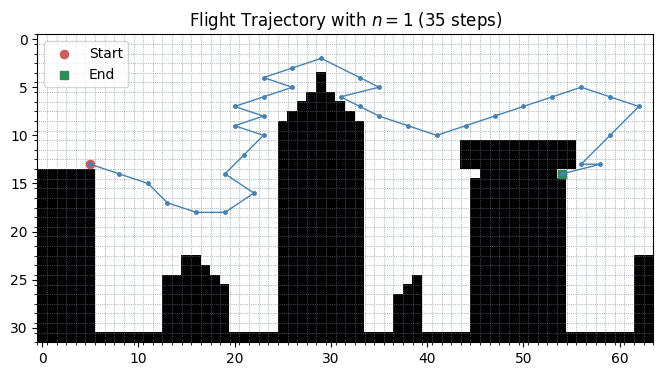

In [162]:
trajectory_1 = get_trajectory(env, policy_1)
plot_trajectory(env, trajectory_1, n_simulations=1)

4. (*) Run Dyna changing the number of simulations run by the agent using $\hat{\mathcal{M}}$, and compare the results.

In [163]:
sim_numbers = [1, 2, 5, 10, 25, 50]
stats_list = [stats_1, stats_2, stats_5, stats_10, stats_25, stats_50]

In [164]:
results = []

for n, stats in zip(sim_numbers, stats_list):
    avg_episode_length = np.mean(stats["episode_length"])
    min_episode_length = np.min(stats["episode_length"])
    max_episode_length = np.max(stats["episode_length"])
    total_running_time = round(stats["running_time"], 3)
    results.append([n, avg_episode_length, min_episode_length, max_episode_length, total_running_time])

headers = ["Planning Steps (n)", "Average Episode Length", "Min Episode Length", "Max Episode Length",
           "Total Running Time (s)"]

print(tabulate(results, headers=headers, tablefmt="simple"))

  Planning Steps (n)    Average Episode Length    Min Episode Length    Max Episode Length    Total Running Time (s)
--------------------  ------------------------  --------------------  --------------------  ------------------------
                   1                   728.415                    35                401179                    27.363
                   2                   502.993                    35                108364                    27.281
                   5                   465.064                    35                106316                    45.578
                  10                   395.784                    35                 68148                    67.006
                  25                   396.953                    35                 92491                   153.798
                  50                   331.078                    35                 36389                   243.786


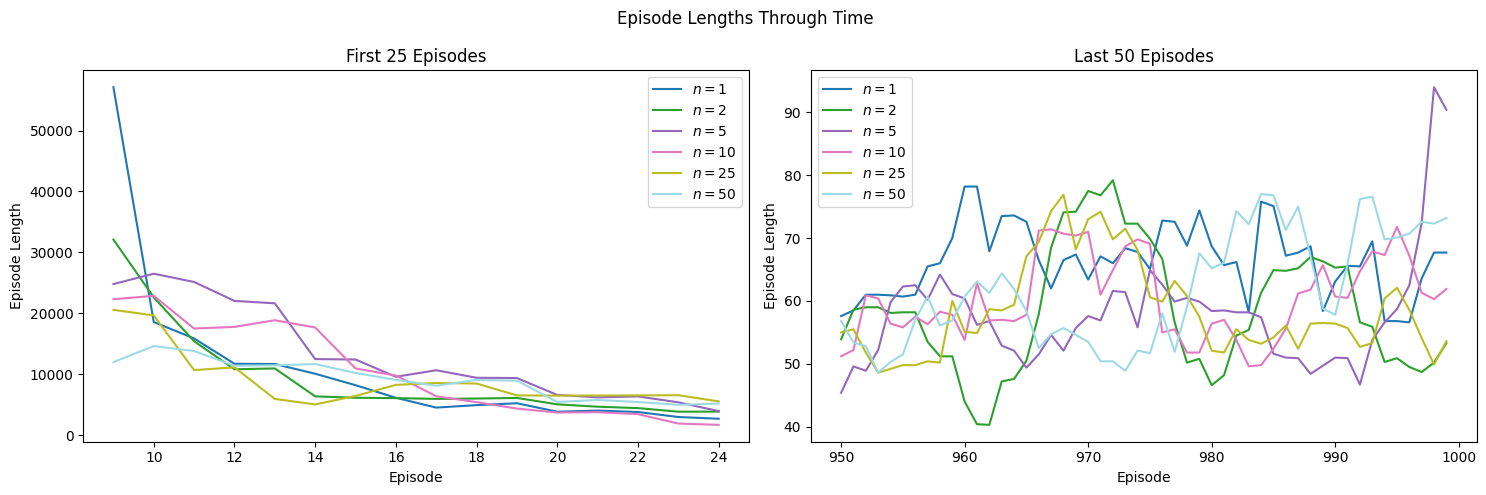

In [165]:
cmap = plt.get_cmap("tab20", len(stats_list))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Episode Lengths Through Time")

for idx, (s_num, stats) in enumerate(zip(sim_numbers, stats_list)):
    color = cmap(idx)
    # 10-episode rolling mean smooths episode lengths, making trends more visible
    episode_rolling_mean = pd.Series(stats["episode_length"]).rolling(10).mean()
    axes[0].plot(episode_rolling_mean[:25], label=f"$n={s_num}$", color=color)
    axes[1].plot(episode_rolling_mean[-50:], label=f"$n={s_num}$", color=color)

axes[0].set_title("First 25 Episodes")
axes[1].set_title("Last 50 Episodes")

for ax in axes:
    ax.set_xlabel("Episode")
    ax.set_ylabel("Episode Length")
    ax.legend()

plt.tight_layout()
plt.show()

In [166]:
fig = make_subplots()

for s_num, stats in zip(sim_numbers, stats_list):
    episode_rolling_mean = pd.Series(stats["episode_length"]).rolling(50).mean()

    fig.add_trace(go.Scatter(x=np.arange(len(episode_rolling_mean)), y=episode_rolling_mean, name=f"n={s_num}"))

fig.update_layout(title_text="Episode Length Over Time",
                  xaxis_title="Number of Episodes", yaxis_title="Episode Length",
                  width=800, height=600)

fig.show()